<h2>Problema 8 Computer Vision</h2>
<hr>
<p>El problema consiste en clasificar distintos tipos de frutas y/o vegetales en <b>frescas</b> o <b>podridas</b>. Para darle un alcance mayor a la solución del problema, el autor de este notebook decidió añadir una funcionalidad extra, clasificar además el tipo de fruta o vegetal siempre y cuando se especifique el tipo en el dataset. Dicho dataset contiene 18 clases: 9 frutas/vegetales frescas y 9 frutas/vegetales podridas, por lo que modelo final devolverá si la fruta o vegetal está fresca o podrida y su tipo.</p>

<h2><i>Obtención de los datos</i></h2>
<hr>
<ol>
<li>
<p>Los datos necesarios para el problema se encuentran <a href="https://share.natasquad.com/index.php/s/D2BHJSt5nY3idPd">aqui</a> por tanto se procede a descargarlos directamente desde el nootebok utilizando el comando wget.</p></li>
<li>
<p>Descomprimir el archivo zip que contiene los datos.</p>
</li>
</ol>

In [19]:
!wget https://share.natasquad.com/index.php/s/D2BHJSt5nY3idPd/download/archive.zip
!unzip "archive.zip"

<h2><i>Importando librerias</i></h2>

In [20]:
import os
import shutil
import random
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import albumentations as A
import torchvision
import torchinfo
from tqdm import tqdm
import numpy as np
import onnxruntime
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline
device = "cuda" if torch.cuda.is_available() else "cpu"

<h2><i>Definiendo las clases</i></h2>
<hr>
<p>A partir de las carpetas del dataset se definen las clases para la clasificación</p>

In [21]:
PATH = "dataset/Train"
PATH_Test = "dataset/New_Test"
if not PATH_Test.split("/")[-1] in os.listdir(PATH[:-6]):
  os.mkdir(PATH_Test)
classes = os.listdir(PATH)
classes.sort()
classes

['freshapples',
 'freshbanana',
 'freshbittergroud',
 'freshcapsicum',
 'freshcucumber',
 'freshokra',
 'freshoranges',
 'freshpotato',
 'freshtomato',
 'rottenapples',
 'rottenbanana',
 'rottenbittergroud',
 'rottencapsicum',
 'rottencucumber',
 'rottenokra',
 'rottenoranges',
 'rottenpotato',
 'rottentomato']

<h2><i>Análisis de los datos</i></h2>
<hr>
<p>Luego de análizar las imágenes del dataset se llegaron a las siguientes conlcusiones:</p>
<ol>
<li>Las imágenes de la carpeta Test eran las mismas de la carpeta Train. Aunque fueran en cantidades diferentes tener imágenes iguales en ambos dataset provocará que la red memorice las características de esa imágen y no se generalice para imágenes nuevas.</li>
<li>En la carpeta Test faltaban 4 clases que estaban presentes en la carpeta Train.</li>
<li>La cantidad de imágenes por clase en la carpeta Test varía mucho lo que provocaría que el sistema validara mejor una clase que otra ya que la información no está balanceada.</li>
<li>Las imágenes poseen distintos tamaños.</li>
</ol>


<h2><i>Creación de un nuevo dataset de evaluación</i></h2>
<hr>
<ol>
<li><p>Se crea una nueva carpeta llamada <b>New_Test.</b></p></li>
<li>Se crean una carpeta por cada clase con el nombre de su clase.</li>
<li>Se seleccionan el 10% de las imágenes de cada clase de forma aleatoria y se mueven de la clase correspondiente en la carpeta Train hacia su clase en la carpeta New_Test.</li>
</ol>

In [22]:
for lab in classes:
  dir = f"{PATH}/{lab}"
  paths = os.listdir(dir)
  imgs = [f"{dir}/{img}" for img in paths]
  
  random_files = random.sample(imgs, (len(paths)*10)//100)
  if not lab in os.listdir(PATH_Test):
    os.mkdir(f"{PATH_Test}/{lab}")
  for img in random_files:
    img_name = img.split("/")[-1]
    shutil.move(img, f"{PATH_Test}/{lab}/{img_name}")


<h2><i>Número de imágenes por categoría del set de entrenamiento</i></h2>

In [23]:
imgs, labels = [],  []

for i, lab in enumerate(classes):
  paths = os.listdir(f"{PATH}/{lab}")
  print(f"Categoria: {lab}. Imagenes: {len(paths)}")
  imgs += [f"{PATH}/{lab}/{img}" for img in paths]
  labels += [i]*len(paths)




Categoria: freshapples. Imagenes: 2182
Categoria: freshbanana. Imagenes: 2222
Categoria: freshbittergroud. Imagenes: 295
Categoria: freshcapsicum. Imagenes: 891
Categoria: freshcucumber. Imagenes: 447
Categoria: freshokra. Imagenes: 572
Categoria: freshoranges. Imagenes: 1320
Categoria: freshpotato. Imagenes: 483
Categoria: freshtomato. Imagenes: 1673
Categoria: rottenapples. Imagenes: 2924
Categoria: rottenbanana. Imagenes: 2639
Categoria: rottenbittergroud. Imagenes: 322
Categoria: rottencapsicum. Imagenes: 811
Categoria: rottencucumber. Imagenes: 379
Categoria: rottenokra. Imagenes: 305
Categoria: rottenoranges. Imagenes: 1436
Categoria: rottenpotato. Imagenes: 722
Categoria: rottentomato. Imagenes: 1643


<h2><i>Algunas imágenes del set de entrenamiento</i></h2>

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


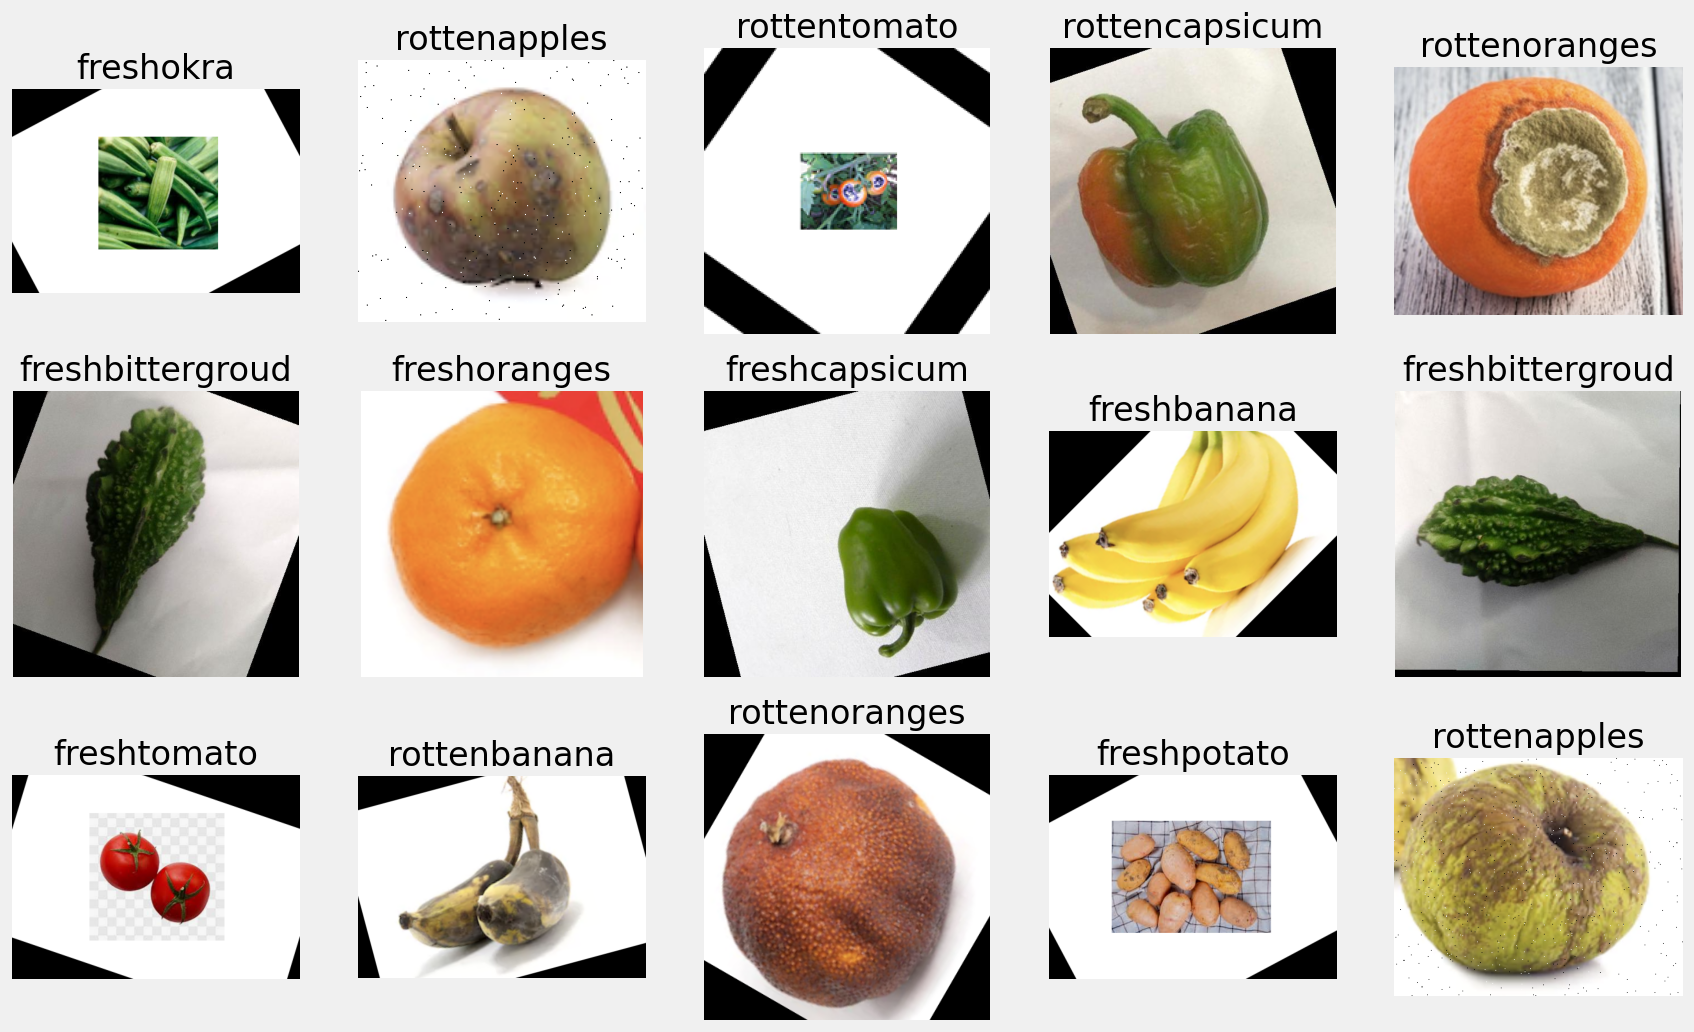

In [24]:
fig, axs = plt.subplots(3,5, figsize=(16,10), dpi=120)
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(imgs)-1)
    img = cv2.imread(imgs[ix])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(classes[labels[ix]])
plt.show()


<h2><i>División de los datos para validación y entrenamiento</i></h2>
<hr>
<h4>Al tener los datos dividos en un conjunto de entrenamiento y otro de prueba se procede a dividir las imágenes en la carpeta Train en un conjunto de entrenamiento y otro de validación. Dividir los datos en conjuntos de entrenamiento, validación y prueba es una práctica fundamental en deep learning y aprendizaje automático en general. Esta división sirve para diferentes propósitos y es esencial para desarrollar modelos precisos y generalizables ya que nos permite:</h4>
<ol>
<li>
<p>Evaluación del rendimiento: El conjunto de prueba se utiliza para evaluar el rendimiento final del modelo una vez que ha sido entrenado y afinado. Al utilizar datos que el modelo nunca ha visto durante el entrenamiento, podemos obtener una estimación más realista de su capacidad para generalizar a datos no vistos.</p>
</li>
<li>
<p>Prevención de sobreajuste: El conjunto de validación se utiliza para ajustar los hiperparámetros del modelo y controlar el sobreajuste. Al ajustar los hiperparámetros en función del rendimiento en el conjunto de validación, podemos elegir el modelo más adecuado sin introducir sesgos basados en los datos de prueba.</p>
</li>
<li>
<p>Selección de modelos: La división en conjuntos de entrenamiento, validación y prueba permite comparar diferentes arquitecturas o enfoques de modelos. El conjunto de validación nos ayuda a seleccionar el mejor modelo antes de probarlo en el conjunto de prueba.</p>
<li>
<p>Estimación de la generalización: Al evaluar el modelo en datos no vistos durante el entrenamiento, podemos obtener una estimación más precisa de cómo se comportará el modelo en el mundo real.</p>
</li>
</ol>

In [25]:
train_imgs, val_imgs, train_labels, val_labels = train_test_split(imgs, labels, test_size=0.2, stratify=labels)
len(train_imgs), len(val_imgs) #cantidad de imagenes por set

(17012, 4254)

<h2><i>Definición de la clase dataset que guardará las imágenes que luego ultilizará la red</i></h2>
<hr>
<p>La clase se define para convertir todas las imágenes a tensores y aplicarle las transformaciones que requiera el usuario</p>


In [26]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, trans, device):
    self.X = X
    self.y = y
    self.trans = trans
    self.device = device

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    img = cv2.imread(self.X[ix])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if self.trans:
      img = self.trans(image=img)["image"]
    return torch.from_numpy(img/255).float().permute(2,0,1), torch.tensor(self.y[ix])

In [27]:
trans = A.Compose(
    [A.Resize(224,224)]
)


dataset = {
    "train": Dataset(train_imgs, train_labels, trans, device),
    "val": Dataset(val_imgs, val_labels, trans, device)
}



len(dataset["train"]), len(dataset["val"])

(17012, 4254)

libpng warning: iCCP: known incorrect sRGB profile


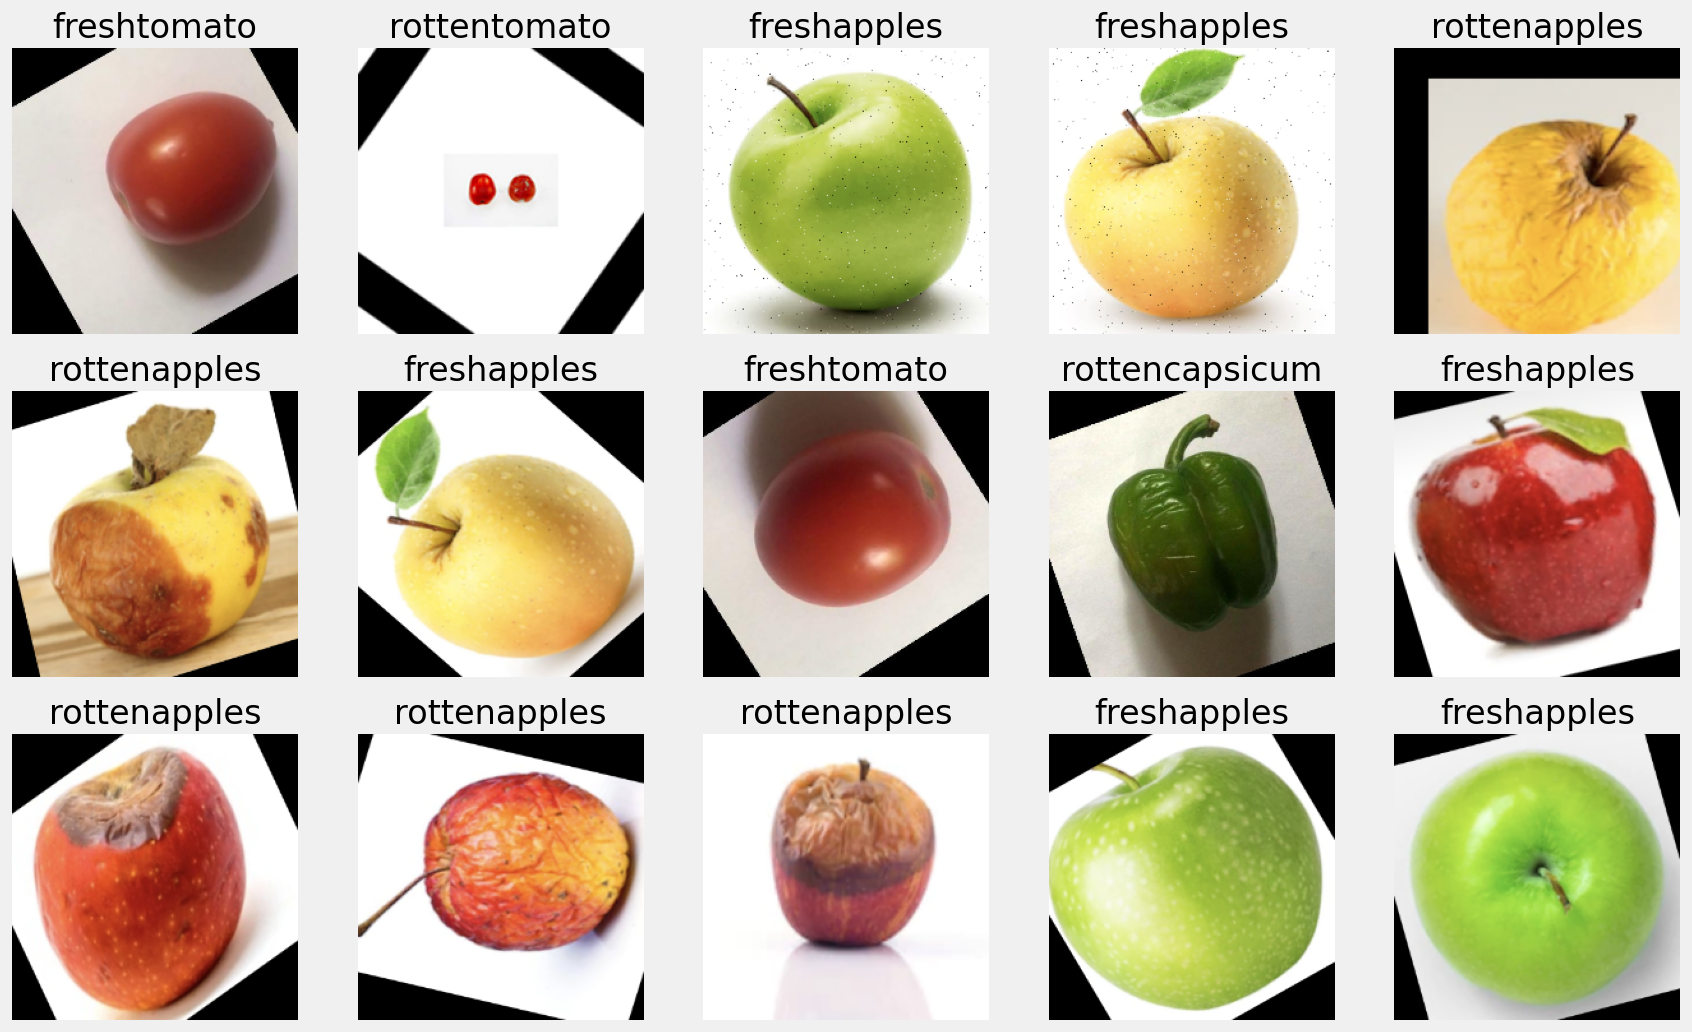

In [28]:
fig, axs = plt.subplots(3,5, figsize=(16,10), dpi=120)
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dataset['train'])-1)
    img, lab = dataset['train'][ix]
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax.set_title(classes[lab])
plt.show()

<h2><i>Creación del Objeto Dataloader:</i></h2>
<hr>
<p>La finalidad del objeto es administrar los datos de manera eficiente, permiten el uso de GPUs de manera efectiva, evitan problemas de memoria y mejoran la calidad del entrenamiento y la evaluación del modelo.</p>


In [29]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True, pin_memory=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=256, shuffle=False)
}

imgs, labels = next(iter(dataloader['train']))
imgs.shape 

libpng warning: iCCP: known incorrect sRGB profile


torch.Size([64, 3, 224, 224])

<h2><i>Modelo a utilizar: Resnet18</i></h2>
<hr>
<p>Para este problema se decidió utilizar la arquitectura ResNet por las siguientes ventajas:</p>
<ol>
<li>
<p>Eficiencia en el entrenamiento y la inferencia: ResNet-18 tiene una arquitectura más liviana en comparación con modelos más grandes, lo que facilita su entrenamiento y permite una inferencia más rápida en dispositivos con recursos limitados.</p>
</li>
<li>
<p>Capacidad para aprender características complejas: La arquitectura residual de ResNet-18 le permite aprender representaciones profundas y complejas de las características, lo que mejora su capacidad para distinguir objetos en imágenes difíciles.</p>
</li>
<li>
<p>Reducción del problema de desvanecimiento del gradiente: Los bloques residuales en ResNet-18 ayudan a mitigar el problema de desvanecimiento del gradiente durante el entrenamiento, lo que facilita el proceso de aprendizaje de la red.</p>
</li>
<li>
<p>Mejor rendimiento en tareas generales de clasificación: ResNet-18 ha demostrado un buen rendimiento en diversas tareas de clasificación de imágenes, como ImageNet, CIFAR-10, entre otras.</p>
</li>
</ol>
<p><b>*Destacar que el modelo final llegó a un 99% de eficacia en solo 8 epochs</b></p>


In [30]:
resnet = torchvision.models.resnet18()
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<h2><i>Definición de la clase modelo</i></h2>
<hr>
<p>Al ser Resnet una arquitectura conocida y poseer un modelo preetrenado, quitamos la última capa de su red y le añadimos una capa lineal que devuelva el numero de valores acorde a las clases de nuestro problema.</hp>

In [31]:
class Model(torch.nn.Module):
  def __init__(self, n_outputs=18, pretrained=False, freeze=False): #aqui se definen las capas de la red
    super().__init__()
    # descargar resnet
    resnet = torchvision.models.resnet18(weights=pretrained)
    # seleccionar todas las capas menos la última
    self.resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
    if freeze:
      for param in self.resnet.parameters():
        param.requires_grad=False
    # añadir una nueva capa lineal para llevar a cabo la clasificación
    self.fc = torch.nn.Linear(512, 18)

  def forward(self, x): #aqui se define el comportamiento de la red
    x = self.resnet(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x


  def unfreeze(self):
    for param in self.resnet.parameters():
        param.requires_grad=True


<h2><i>Resúmen de las principales características de la red</i></h2>
<hr>

In [32]:
model = Model()
outputs = model(torch.randn(64, 3, 224, 224))
print(outputs.shape) #comprobando la salida de la red
torchinfo.summary(model, (3, 224, 224), batch_dim = 0, col_names = ("input_size", "output_size", "num_params", "kernel_size", "mult_adds"), verbose = 0)

torch.Size([64, 18])


Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
Model                                         [1, 3, 224, 224]          [1, 18]                   --                        --                        --
├─Sequential: 1-1                             [1, 3, 224, 224]          [1, 512, 1, 1]            --                        --                        --
│    └─Conv2d: 2-1                            [1, 3, 224, 224]          [1, 64, 112, 112]         9,408                     [7, 7]                    118,013,952
│    └─BatchNorm2d: 2-2                       [1, 64, 112, 112]         [1, 64, 112, 112]         128                       --                        128
│    └─ReLU: 2-3                              [1, 64, 112, 112]         [1, 64, 112, 112]         --                        --                        --
│    └─MaxPool2d: 2-4                         [1, 64, 112, 112]  

<h2><i>Conjunto de funciones útiles para el modelo</i></h2>
<hr>
<p>Aqui se definen las funciones que permitirán entrenar, exportar y evaluar nuestro modelo</p>
<p>Se decide exportar el modelo a formato ONNX por las siguietes razones:</p>
<ol>
<li>
<p>Portabilidad: ONNX es un formato de intercambio abierto y estándar para modelos de aprendizaje profundo. Esto significa que se puede utilizar en diferentes frameworks y plataformas, lo que facilita la portabilidad del modelo entre diferentes entornos de desarrollo y ejecución.</p>
</li>
<li>
<p>Compatibilidad multiplataforma: Al exportar el modelo a ONNX, se puede utilizar en una amplia gama de dispositivos y arquitecturas, incluyendo CPU, GPU, FPGA y dispositivos móviles. Esto permite una mayor flexibilidad en la implementación y ejecución del modelo en diferentes sistemas.</p>
</li>
<li>
<p>Optimización y aceleración: Una vez que el modelo se encuentra en el formato ONNX, es posible aplicar técnicas de optimización y aceleración específicas para la plataforma de destino. Esto puede mejorar significativamente el rendimiento del modelo y reducir el tiempo de inferencia.</p>
</li>
<li>
<p>Colaboración y reutilización: ONNX facilita la colaboración entre equipos que utilizan diferentes frameworks de aprendizaje profundo. También permite la reutilización de modelos entrenados en diferentes proyectos y aplicaciones.</p>
</li>
<li>
<p>Futuro y comunidad: ONNX es respaldado por una comunidad activa y se está convirtiendo rápidamente en un estándar de la industria. Exportar un modelo a ONNX asegura que esté listo para las innovaciones futuras y las mejoras que puedan surgir en el ecosistema del aprendizaje profundo.</p>
</li>
</ol>

In [33]:
def fit(model, dataloader, epochs=8, lr=1e-2):
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr) #optimizador
    criterion = torch.nn.CrossEntropyLoss() #función para calcular la pérdida
    for epoch in range(1, epochs+1):
        print(f"Epoch {epoch}/{epochs}")
        print("-"*10)
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['val'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print("Final Results:")
        print(f"loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")
        print("-"*10)

def export_model(model, model_name, input_example):
  # exportamos el modelo
  model_name += ".onnx"
  torch.onnx.export(model,                     # el modelo
                    input_example,                         # un ejemplo del input
                    model_name,              # el nombre del archivo para guardar el modelo
                    export_params=True,        # guardar los pesos de la red
                    opset_version=10,          # versión de ONNX
                    do_constant_folding=True,  # optimizaciones
                    input_names = ['input'],   # nombre de los inputs
                    output_names = ['output'], # nombre de los outputs
                    dynamic_axes={'input' : {0 : 'batch_size'},    # ejes con longitud variable (para poder usar diferentes tamaños de batch)
                                  'output' : {0 : 'batch_size'}})

def onnx_evaluate(model, model_name, dataloader):
    # cargarmos el modelo
    print(f"Evaluating: {model_name}")
    ort_session = onnxruntime.InferenceSession(model)
    bar = tqdm(dataloader)
    acc = []

    with torch.no_grad():
        for batch in bar:
          X, y = batch
          X, y = X.numpy(), y.numpy()
          # generamos los inputs
          ort_inputs = {ort_session.get_inputs()[0].name: X}
          # extraemos los outputs
          ort_outs = ort_session.run(None, ort_inputs)[0]
          acc.append((y == np.argmax(ort_outs, axis=1)).mean())
          bar.set_description(f"acc {np.mean(acc):.5f}")

<h2><i>Entrenamiento del modelo</i></h2>
<hr>
<p>Se decide entrenar el modelo de distintas formas buscando una mayor eficacia</p>

<h2><i>Modelo entrenado desde cero</i></h2>

In [34]:
model_resnet_primitive = Model()
fit(model_resnet_primitive, dataloader)

x = torch.randn(64, 3, 224, 224) 
y = model_resnet_primitive.cpu()(x)
export_model(model_resnet_primitive, "model_resnet_primitive", x)

Epoch 1/8
----------


  0%|          | 0/266 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 2.92646 acc 0.03125:   1%|          | 2/266 [00:06<13:36,  3.09s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 2.84906 acc 0.06250:   1%|          | 3/266 [00:09<13:19,  3.04s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 2.82853 acc 0.08594:   2%|▏         | 4/266 [00:12<12:56,  2.97s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 2.79443 acc 0.10000:   2%|▏         | 5/266 [00:16<14:31,  3.34s/it]libpng

Final Results:
loss 1.33501 val_loss 1.17561 acc 0.60050 val_acc 0.61369
----------
Epoch 2/8
----------


  0%|          | 0/266 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 0.80026 acc 0.71875:   0%|          | 1/266 [00:03<16:01,  3.63s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 0.76370 acc 0.73438:   1%|          | 2/266 [00:07<15:50,  3.60s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 0.72480 acc 0.76042:   1%|          | 3/266 [00:10<15:50,  3.61s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 0.71828 acc 0.76250:   2%|▏         | 5/266 [00:17<15:32,  3.57s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng

Final Results:
loss 0.56355 val_loss 0.51778 acc 0.81377 val_acc 0.81379
----------
Epoch 3/8
----------


  0%|          | 0/266 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 0.60667 acc 0.76562:   0%|          | 1/266 [00:03<16:47,  3.80s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 0.58462 acc 0.74219:   1%|          | 2/266 [00:07<16:03,  3.65s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 0.53197 acc 0.78125:   1%|          | 3/266 [00:11<17:05,  3.90s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known 

Final Results:
loss 0.39551 val_loss 0.39830 acc 0.86274 val_acc 0.85383
----------
Epoch 4/8
----------


  0%|          | 0/266 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 0.36859 acc 0.81250:   0%|          | 1/266 [00:03<16:15,  3.68s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 0.31642 acc 0.89062:   2%|▏         | 5/266 [00:18<16:01,  3.68s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 0.33798 acc 0.87500:   2%|▏         | 6/266 [00:22<16:15,  3.75s/it]libpng warning: iCCP: known 

Final Results:
loss 0.31121 val_loss 0.64641 acc 0.89180 val_acc 0.78496
----------
Epoch 5/8
----------


  0%|          | 0/266 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 0.35231 acc 0.84375:   0%|          | 1/266 [00:03<16:42,  3.78s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 0.27443 acc 0.88281:   1%|          | 2/266 [00:07<16:05,  3.66s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 0.25954 acc 0.88542:   1%|          | 3/266 [00:11<17:15,  3.94s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known 

Final Results:
loss 0.26707 val_loss 0.71795 acc 0.90430 val_acc 0.77060
----------
Epoch 6/8
----------


  0%|          | 0/266 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 0.18518 acc 0.89062:   0%|          | 1/266 [00:03<16:33,  3.75s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 0.25341 acc 0.88281:   1%|          | 2/266 [00:07<16:02,  3.64s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 0.30052 acc 0.86979:   1%|          | 3/266 [00:11<16:28,  3.76s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known 

Final Results:
loss 0.23449 val_loss 0.27600 acc 0.91620 val_acc 0.89403
----------
Epoch 7/8
----------


  0%|          | 0/266 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 0.20977 acc 0.94531:   1%|          | 2/266 [00:07<16:37,  3.78s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 0.23289 acc 0.93750:   1%|          | 3/266 [00:11<16:09,  3.69s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 0.20687 acc 0.94141:   2%|▏         | 4/266 [00:14<15:50,  3.63s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 0.20247 acc 0.94375:   

Final Results:
loss 0.21085 val_loss 0.33075 acc 0.92418 val_acc 0.88183
----------
Epoch 8/8
----------


  0%|          | 0/266 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 0.24523 acc 0.90625:   0%|          | 1/266 [00:03<17:22,  3.93s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 0.20314 acc 0.93229:   1%|          | 3/266 [00:11<16:38,  3.80s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 0.17717 acc 0.94063:   2%|▏         | 5/266 [00:18<16:18,  3.75s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 0.17912 acc 0.93750:   2%|▏         | 6/266 [00:22<16:12,  3.74s/it]libpng

Final Results:
loss 0.18085 val_loss 1.05307 acc 0.93604 val_acc 0.73760
----------
============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



<h2><i>Modelo con los pesos preentrenados entrenando solamente la nueva capa añadida</i></h2>

In [35]:
model_resnet_pretrained_freezze = Model(pretrained=True, freeze=True)
fit(model_resnet_pretrained_freezze, dataloader)
x = torch.randn(64, 3, 224, 224)
y = model_resnet_pretrained_freezze.cpu()(x)
export_model(model_resnet_pretrained_freezze, "model_resnet_pretrained_freezze", x)

Epoch 1/8
----------


  0%|          | 0/266 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 3.12963 acc 0.03125:   0%|          | 1/266 [00:01<06:25,  1.45s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 3.03980 acc 0.07812:   1%|          | 3/266 [00:04<07:12,  1.65s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 2.95421 acc 0.10156:   2%|▏         | 4/266 [00:06<07:07,  1.63s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 2.87291 acc 0.12187:   2%|▏         | 5/266 [00:08<07:10,  1.65s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 2.81242 acc 0.14062:   2%|▏         | 6/266 [00:09<0

Final Results:
loss 1.04610 val_loss 0.49713 acc 0.76404 val_acc 0.90586
----------
Epoch 2/8
----------


loss 0.51106 acc 0.90625:   0%|          | 1/266 [00:01<07:27,  1.69s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 0.47363 acc 0.92969:   1%|          | 2/266 [00:03<07:42,  1.75s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 0.50627 acc 0.91667:   1%|          | 3/266 [00:05<07:27,  1.70s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 0.53383 acc 0.91016:   2%|▏         | 4/266 [00:07<08:17,  1.9

Final Results:
loss 0.41595 val_loss 0.32010 acc 0.91943 val_acc 0.93613
----------
Epoch 3/8
----------


loss 0.31054 acc 0.93750:   0%|          | 1/266 [00:01<07:25,  1.68s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 0.34574 acc 0.92188:   1%|          | 2/266 [00:03<07:59,  1.82s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 0.30170 acc 0.93750:   1%|          | 3/266 [00:05<07:39,  1.75s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 0.30547 acc 0.92969:   2%|▏         | 4/266 [00:07<07:54,  1.81s/it]libpng warning: iCCP: known incorrect sRGB pr

Final Results:
loss 0.29978 val_loss 0.25510 acc 0.94008 val_acc 0.94833
----------
Epoch 4/8
----------


  0%|          | 0/266 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 0.25901 acc 0.95312:   0%|          | 1/266 [00:01<07:20,  1.66s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 0.24114 acc 0.96094:   1%|          | 2/266 [00:03<07:15,  1.65s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 0.24168 acc 0.95833:   1%|          | 3/266 [00:04<07:11,  1.64s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known 

Final Results:
loss 0.24987 val_loss 0.22410 acc 0.94593 val_acc 0.95095
----------
Epoch 5/8
----------


  0%|          | 0/266 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 0.25457 acc 0.95312:   0%|          | 1/266 [00:01<06:58,  1.58s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 0.28323 acc 0.92969:   1%|          | 2/266 [00:03<07:19,  1.66s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 0.25596 acc 0.94792:   1%|          | 3/266 [00:05<07:22,  1.68s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 0.26350 acc 0.94922:   2%|▏         | 4/266 [00:06<07:13,  1.65s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng

Final Results:
loss 0.21759 val_loss 0.19575 acc 0.95264 val_acc 0.95316
----------
Epoch 6/8
----------


  0%|          | 0/266 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 0.12432 acc 1.00000:   0%|          | 1/266 [00:01<06:59,  1.58s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 0.14651 acc 0.98438:   1%|          | 2/266 [00:03<06:59,  1.59s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 0.15613 acc 0.98438:   1%|          | 3/266 [

Final Results:
loss 0.19894 val_loss 0.18259 acc 0.95543 val_acc 0.95554
----------
Epoch 7/8
----------


loss 0.19236 acc 0.93750:   0%|          | 1/266 [00:01<06:46,  1.53s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 0.20767 acc 0.93750:   1%|          | 2/266 [00:03<07:14,  1.65s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 0.21523 acc 0.93229:   1%|          | 3/266 [00:05<07:34,  1.73s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 0.20728 acc 0.94141:   2%|▏         | 4/266 [00:07<07:57,  1.82s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB pr

Final Results:
loss 0.18197 val_loss 0.16828 acc 0.95928 val_acc 0.96005
----------
Epoch 8/8
----------


  0%|          | 0/266 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 0.16349 acc 0.98438:   0%|          | 1/266 [00:01<08:15,  1.87s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 0.13762 acc 0.98438:   1%|          | 2/266 [00:03<07:29,  1.70s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 0.14985 acc 0.97266:   2%|▏         | 4/266 [00:07<07:51,  1.80s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known 

Final Results:
loss 0.17027 val_loss 0.16039 acc 0.96222 val_acc 0.96134
----------
============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



<h2><i>Modelo con los pesos preentrenados entrenando toda la red</i></h2>

In [36]:
model_resnet_pretrained_notfreezze = Model(pretrained=True, freeze=False)
fit(model_resnet_pretrained_notfreezze, dataloader)
x = torch.randn(64, 3, 224, 224)
y = model_resnet_pretrained_notfreezze.cpu()(x)
export_model(model_resnet_pretrained_notfreezze, "model_resnet_pretrained_notfreezze", x)

Epoch 1/8
----------


  0%|          | 0/266 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 2.83313 acc 0.09375:   1%|          | 2/266 [00:08<19:54,  4.53s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 2.77045 acc 0.12500:   1%|          | 3/266 [00:13<19:33,  4.46s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 2.71109 acc 0.14453:   2%|▏         | 4/266 [00:17<19:20,  4.43s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 2.66180 acc 0.16562:   2%|▏         | 5/266 [00:21<18:19,  4.21s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng

Final Results:
loss 0.49399 val_loss 0.13299 acc 0.88923 val_acc 0.97002
----------
Epoch 2/8
----------


  0%|          | 0/266 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 0.18111 acc 0.96875:   0%|          | 1/266 [00:03<15:25,  3.49s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 0.13898 acc 0.97656:   1%|          | 2/266 [00:07<15:45,  3.58s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
loss 0.13903 acc 0.97396:   1%|          | 3/266 [00:10<16:08,  3.68s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known 

KeyboardInterrupt: 

In [ ]:
model_resnet_pretrained_freezze.unfreeze()
fit(model_resnet_pretrained_freezze, dataloader, lr=1e-3)
x = torch.randn(64, 3, 224, 224)
y = model_resnet_pretrained_freezze.cpu()(x)
export_model(model_resnet_pretrained_freezze, "model_resnet_pretrained_un-freezze", x)

<h2><i>Creación del objeto dataset y dataloader para las imágenes del Test luego de entrenado el modelo</i></h2>

In [37]:
test_imgs, test_labels = [],  []
for i, lab in enumerate(classes):
  paths = os.listdir(f"{PATH_Test}/{lab}")
  print(f"Categoria: {lab}. Imagenes: {len(paths)}")
  test_imgs += [f"{PATH_Test}/{lab}/{img}" for img in paths]
  test_labels += [i]*len(paths)

trans = A.Compose(
    [A.Resize(224,224)]
)

test_dataset = Dataset(test_imgs, test_labels, trans, device)
test_dataloader = torch.utils.data.DataLoader(test_dataset)
len(test_dataloader)

Categoria: freshapples. Imagenes: 242
Categoria: freshbanana. Imagenes: 246
Categoria: freshbittergroud. Imagenes: 32
Categoria: freshcapsicum. Imagenes: 99
Categoria: freshcucumber. Imagenes: 49
Categoria: freshokra. Imagenes: 63
Categoria: freshoranges. Imagenes: 146
Categoria: freshpotato. Imagenes: 53
Categoria: freshtomato. Imagenes: 185
Categoria: rottenapples. Imagenes: 324
Categoria: rottenbanana. Imagenes: 293
Categoria: rottenbittergroud. Imagenes: 35
Categoria: rottencapsicum. Imagenes: 90
Categoria: rottencucumber. Imagenes: 42
Categoria: rottenokra. Imagenes: 33
Categoria: rottenoranges. Imagenes: 159
Categoria: rottenpotato. Imagenes: 80
Categoria: rottentomato. Imagenes: 182


2353

<h2><i>Evaluación de los modelos:</i></h2>
<hr>
<p>Luego del entrenamiento y exportación del modelo se procede a evaluarlo con los datos de Test que el modelo nunca ha visto</p>

In [38]:
models_onnx = [
    "model_resnet_pretrained_notfreezze.onnx",
    "model_resnet_pretrained_un-freezze.onnx",
    "model_resnet_primitive.onnx",
    "model_resnet_pretrained_freezze.onnx"
]


In [39]:
for model in models_onnx:
  model_name = model.split("/")[-1].split(".")[0]
  onnx_evaluate(model, model_name , test_dataloader)

Evaluating: model_resnet_pretrained_notfreezze


acc 0.99575: 100%|██████████| 2353/2353 [00:57<00:00, 41.07it/s]


Evaluating: model_resnet_pretrained_un-freezze


acc 0.99193: 100%|██████████| 2353/2353 [00:51<00:00, 45.26it/s]


Evaluating: model_resnet_primitive


acc 0.74331: 100%|██████████| 2353/2353 [00:52<00:00, 44.72it/s]


Evaluating: model_resnet_pretrained_freezze


acc 0.96515: 100%|██████████| 2353/2353 [00:52<00:00, 44.49it/s]


<h2><i>Funciones útiles para las predicciones del modelo</i></h2>

In [40]:
def predict(model, dataloader):
  ort_session = onnxruntime.InferenceSession(model)
  bar = tqdm(dataloader)
  predictions = []  # Lista para almacenar las predicciones
  with torch.no_grad():  # Deshabilitar el cálculo del gradiente durante la inferencia
      for batch in bar:
        X, y = batch
        X, y = X.numpy(), y.numpy()
        ort_inputs = {ort_session.get_inputs()[0].name: X}
        # extraemos los outputs
        ort_outs = ort_session.run(None, ort_inputs)[0]
        predicted_labels = np.argmax(ort_outs, axis=1)[0]

        ## Agregar las predicciones a la lista
        predictions.append(predicted_labels)

  return predictions


def show_predictions(predictions, classes):
  results = []
  for i, lab in enumerate(classes):
    for pred in predictions:
      if pred == i:
        results.append(lab)
  return results

<h2><i>Resultados de las métricas para las predicciones del modelo</i></h2>
<hr>
<p>Utilizando el modelo con mayor eficacia en la evaluación, "model_resnet_pretrained_notfreezze.onnx", calculamos otras métricas de evaluación</p>

In [41]:
predictions = predict(models_onnx[0], test_dataloader)
test_labels, predictions = np.array(test_labels) , np.array(predictions)
report = classification_report(test_labels, predictions, zero_division=0.0, output_dict=True )
# Obtener el reporte de clasificación como un diccionario

report_dict = classification_report(test_labels, predictions, output_dict=True)

# Convertir el diccionario en un DataFrame de pandas para mostrarlo como una tabla
report_df = pd.DataFrame(report_dict).transpose()

# Imprimir el DataFrame formateado
report_df



  0%|          | 0/2353 [00:00<?, ?it/s]

 40%|███▉      | 930/2353 [00:20<00:22, 61.97it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
 40%|███▉      | 937/2353 [00:20<00:23, 61.00it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
 41%|████      | 956/2353 [00:20<00:28, 49.14it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
 41%|████▏     | 972/2353 [00:20<00:29, 46.66it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
 42%|████▏     | 979/2353 [00:21<00:26, 51.39it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
 43%|████▎     | 1005/2353 [00:21<00:29, 45.86it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
 44%|████▎     | 1025/2353 [00:22<00:23, 55.57it/s]libpng warning: iCCP: known incorrec

precision    recall  f1-score     support
0              1.000000  1.000000  1.000000   242.00000
1              1.000000  1.000000  1.000000   246.00000
2              1.000000  1.000000  1.000000    32.00000
3              1.000000  1.000000  1.000000    99.00000
4              1.000000  0.959184  0.979167    49.00000
5              1.000000  1.000000  1.000000    63.00000
6              1.000000  1.000000  1.000000   146.00000
7              1.000000  0.943396  0.970874    53.00000
8              1.000000  1.000000  1.000000   185.00000
9              0.996923  1.000000  0.998459   324.00000
10             1.000000  1.000000  1.000000   293.00000
11             1.000000  1.000000  1.000000    35.00000
12             1.000000  1.000000  1.000000    90.00000
13             0.909091  0.952381  0.930233    42.00000
14             0.968750  0.939394  0.953846    33.00000
15             1.000000  0.993711  0.996845   159.00000
16             0.952381  1.000000  0.975610    80.00000
17             1.000000  1.000000  1.000000   182.00000
accuracy       0.995750  0.995750  0.995750     0.99575
macro avg      0.990397  0.988226  0.989169  2353.00000
weighted avg   0.995896  0.995750  0.995763  2353.00000

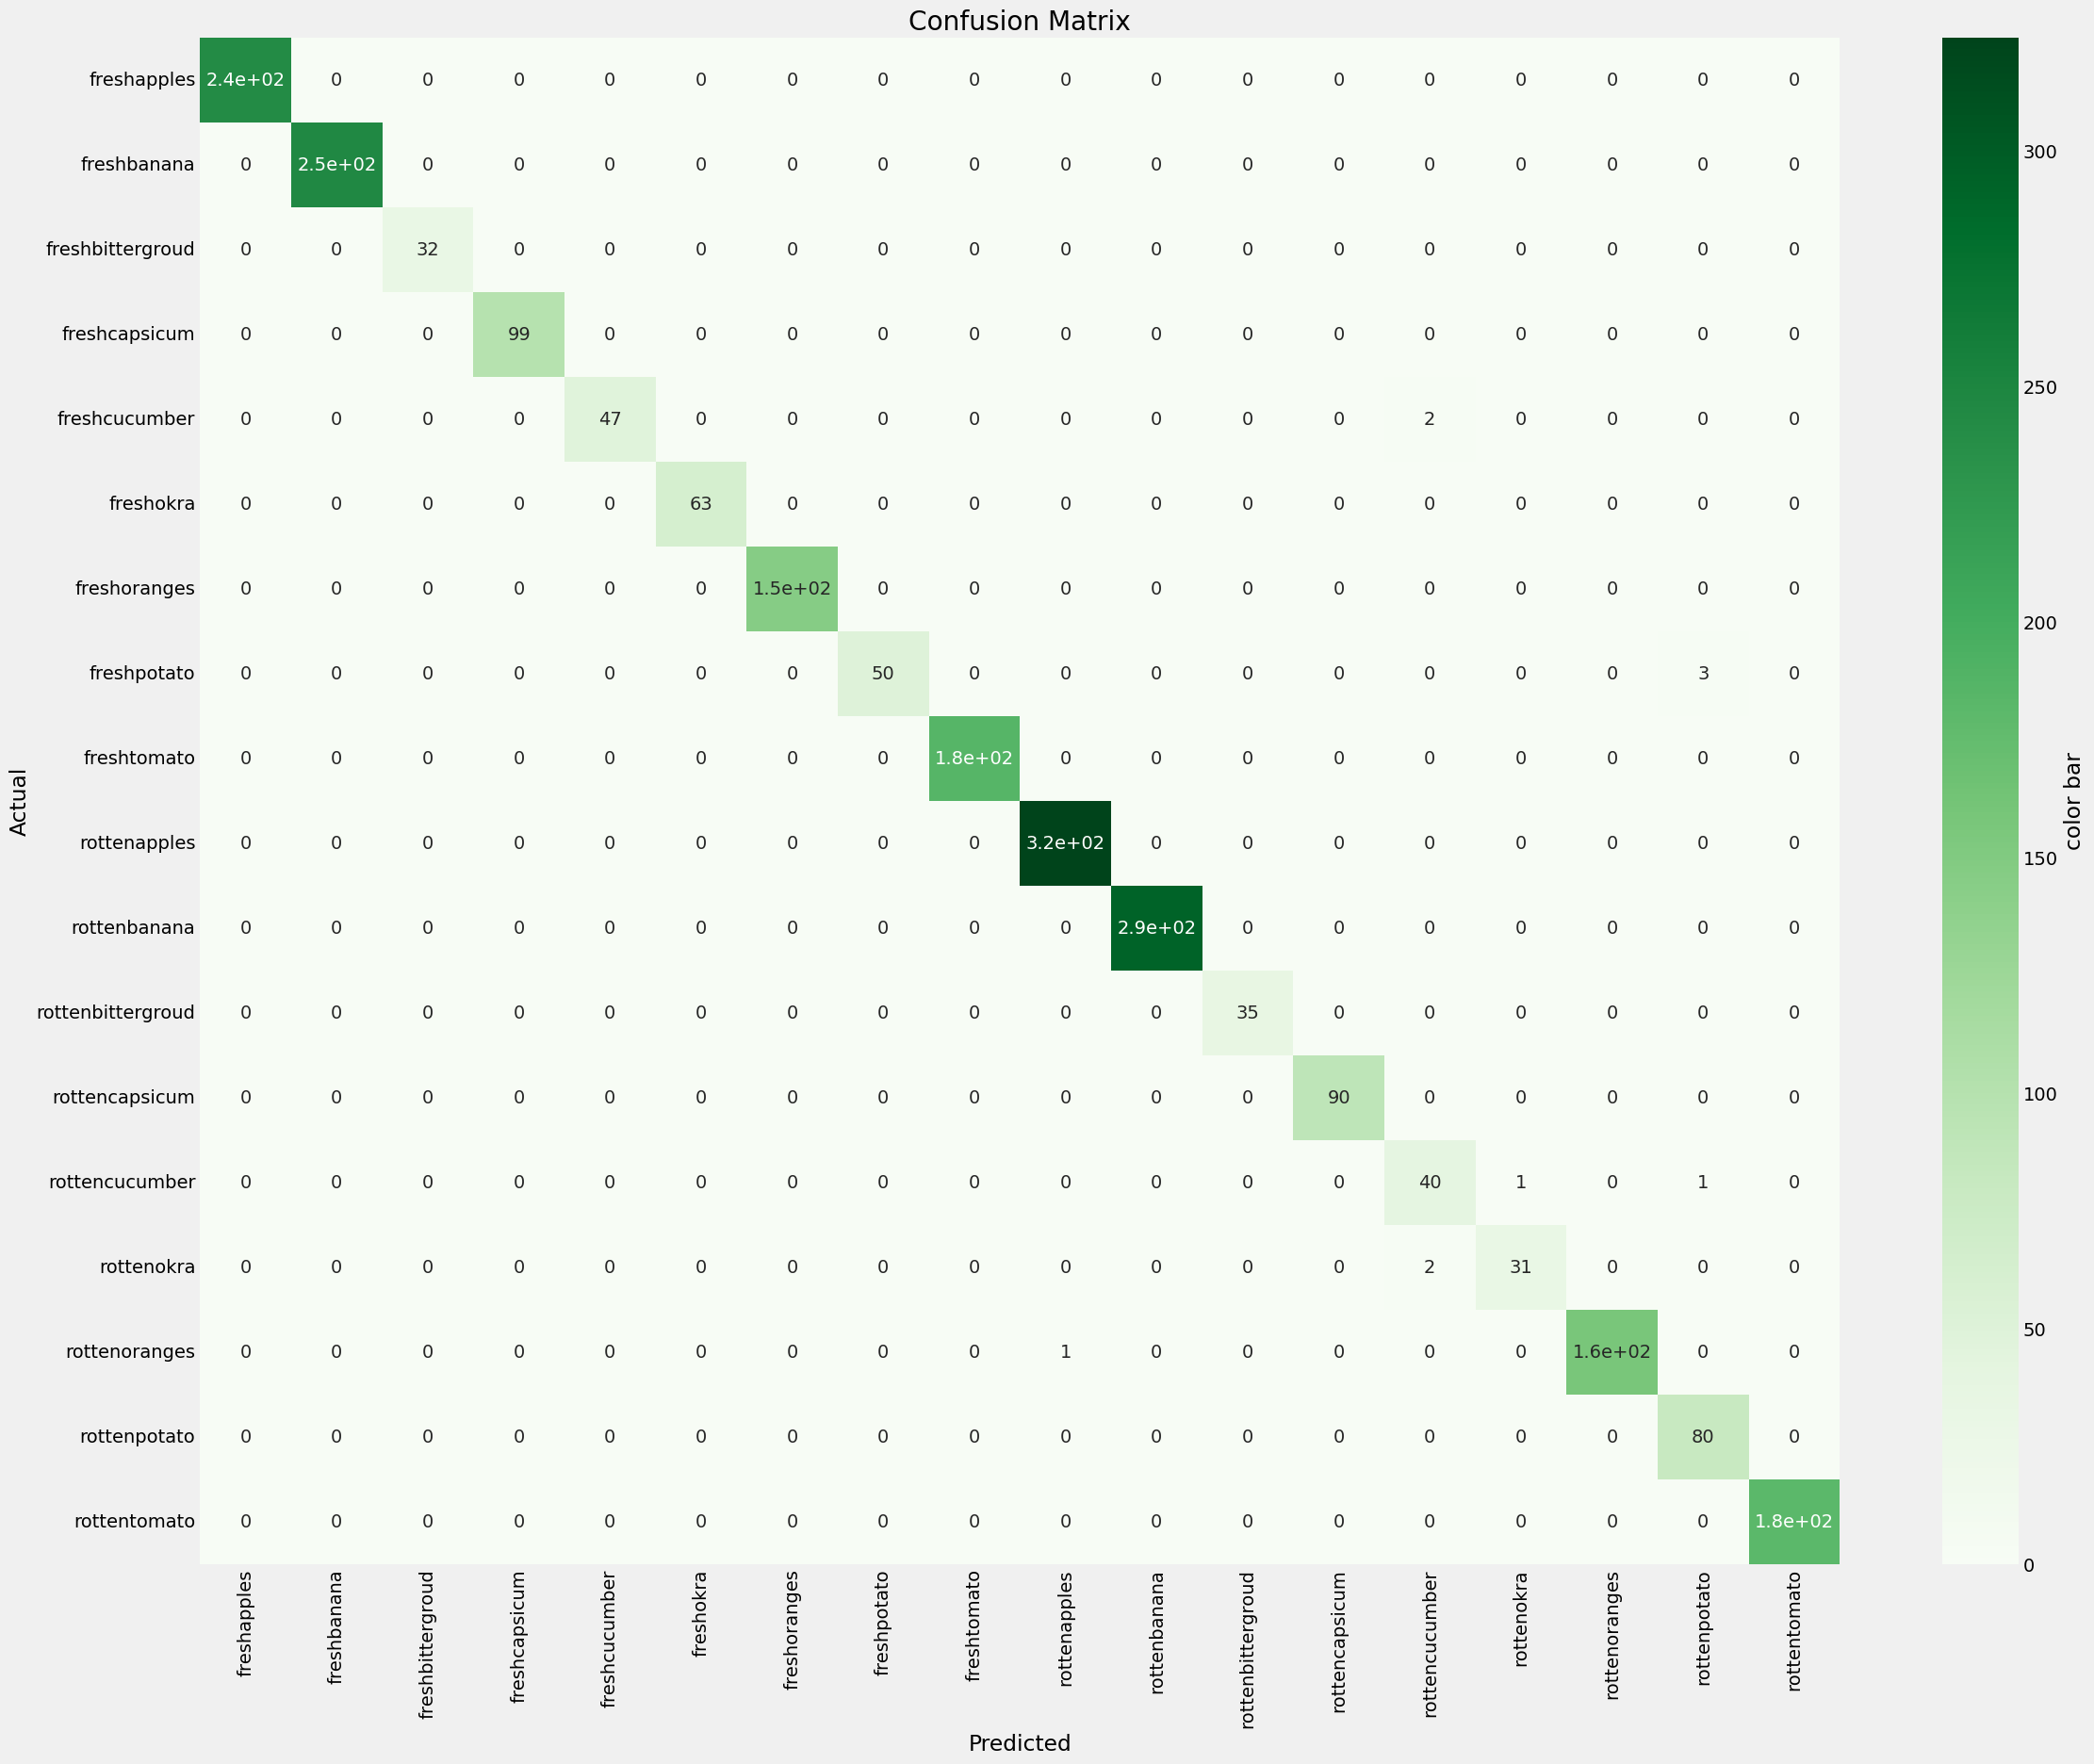

In [42]:
test_labels_len = len(test_labels)
cm=confusion_matrix(test_labels,predictions,labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17])
plt.figure(figsize=(25, 20))
sns.heatmap(cm,cmap="Greens",annot=True,
            cbar_kws={"orientation":"vertical","label":"color bar"},
            xticklabels=classes,yticklabels=classes)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

<h2><i>Algunas imágenes que predijo el modelo</i></h2>

libpng warning: iCCP: known incorrect sRGB profile


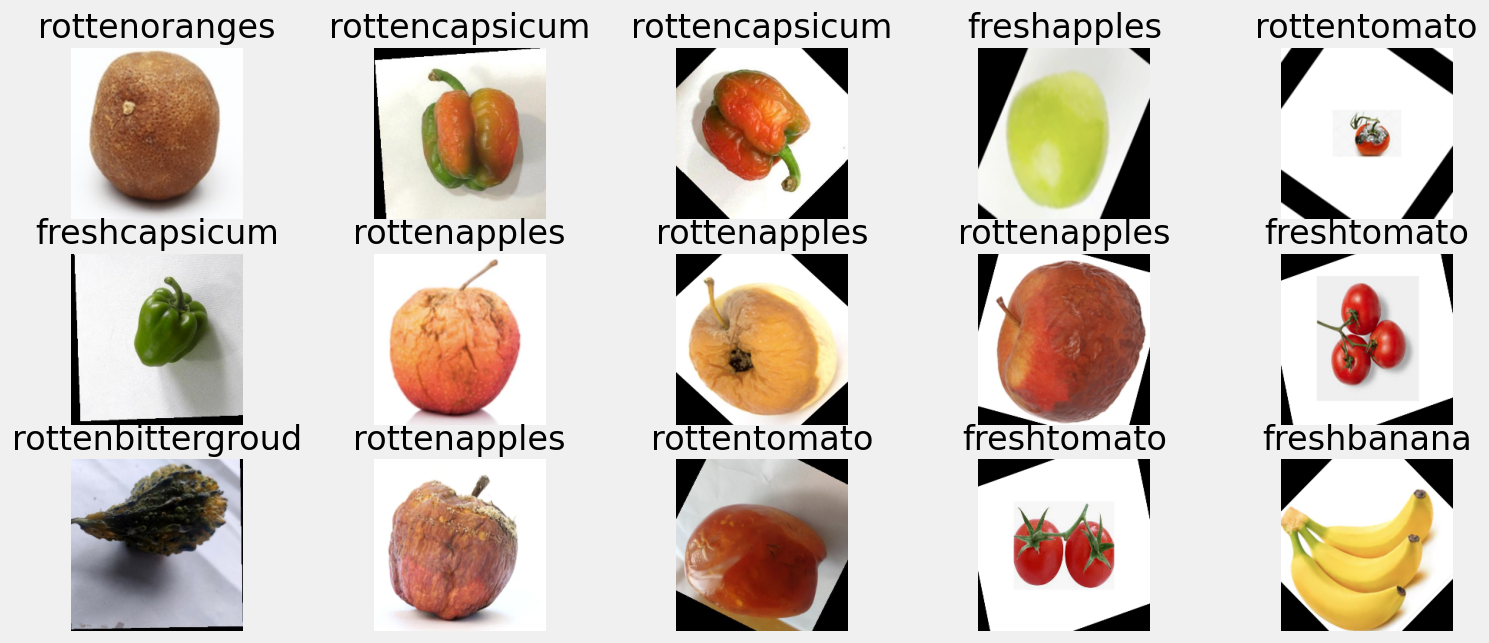

In [43]:
label_predictions = show_predictions(predictions, classes)

fig, axs = plt.subplots(3,5, figsize=(14,6), dpi=120)
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(test_dataset)-1)
    img, _ = test_dataset[ix]
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax.set_title(label_predictions[ix])
plt.show()

